# **The Wine Alliance**
# Applied Data Science - Coursera
## Capstone Project Course
*by Leopoldo Sprandel*


### Business Problem
In May 25th we celebrate the National Wine Day in Brazil. All enthusiasts participates on a two weeks of appreciation, learning sections and winery visits around the country. 
This event promotes the interchange of producers, wine shops and consumers moving all economy around the wine.  
The tourism in the city of São Paulo is in the rout of the event.  
Now imagine we want to choose some Wine Bars in the city to organize a large alliance between them to promote the consumers interchange over the Wine shops.  
The Wine shops need to be well known and we are looking for somehow connections between them.

### Data
The data we choose to select the wine bars that can participate on this alliance are the stores with high recommendations and are part of a network based on the public. 

So, we need to answer two questions:  
- Which wine bars in São Paulo are best evaluated?
- Is the wine bars connected? Which winery shares the same public?  

To answer these questions we can analyze the wine shops listed in the Foursquare API in the city of São Paulo, regarding the following points:
- Check the rank of wine bars (the first 100th)  

| Wine bar | Ranking  |  
|------|------|  
|   WineBarA  | 1|  
|   WineBarB  | 2|  
|   WineBarC  | 3|  
|   WineBarC  | 4|  
|   WineBar...  | ...|  
|   WineShopX  | 100|  

- A network representation can be done connecting stores who shares the same consumer (signalised by the likes or tips).

| Wine Store | Conections  |  
|------|------|  
|   WineBarA  | WineBarB, WineBarC|  
|   WineBarB  | WineBarA, WineBarC, WineBarD, WineBarX|  
|   WineBarC  | ...|   


### Import the libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import requests as rq# library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import folium # map rendering library

#to deal with web sites information
from bs4 import BeautifulSoup

# to clustering data
from sklearn.cluster import KMeans

#to creating and manipulating complex networks
import networkx as nx

# convert an address into latitude and longitude values
from geopy.geocoders import Nominatim 

# To work with word clouds
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
from PIL import Image # converting images into arrays

### Get the Wine Shops in São Paulo

In [2]:
# the localization of São Paulo and create a DataFrame with the inputs

latitude = -23.5474277
longitude = -46.637165

dfwinebars=pd.DataFrame(data={'City':['São Paulo'], 'Latitude':[latitude], 'Longitude':[longitude], 'Query':['wine']})
dfwinebars

,City,Latitude,Longitude,Query
0,São Paulo,-23.547428,-46.637165,wine


In [3]:
# hidden_cell
# credentials to acces the Foursquare API
CLIENT_ID = 'xxx' # your Foursquare ID
CLIENT_SECRET = 'xxx' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [4]:
# get the top 100 wine bars that are in São paulo  (from the center city 10km radius)
def getNearbyVenues(names, latitudes, longitudes, Query, radius=10000,LIMIT=100):
    
    venues_list=[]
    for name, lat, lng, quer in zip(names, latitudes, longitudes, Query):
       # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&query={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            quer,
            LIMIT
            )
#        print(url)    
        # make the GET request
        results = rq.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            v['venue']['name'], 
            v['venue']['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'Venue', 
                  'VenueId',
                  'Latitude', 
                  'Longitude', 
                  'Category']
    return(nearby_venues)

In [5]:
SPwinebars = getNearbyVenues(names=dfwinebars['City'],
                                   latitudes=dfwinebars['Latitude'],
                                   longitudes=dfwinebars['Longitude'],
                                   Query=dfwinebars['Query']
                                )
SPwinebars.head()

,City,Venue,VenueId,Latitude,Longitude,Category
0,São Paulo,Banca do Ramon,4d9750972bd6f04dd4444c50,-23.541517,-46.629454,Wine Shop
1,São Paulo,Mistral,4bd30fae462cb7132169dd07,-23.558903,-46.649762,Wine Shop
2,São Paulo,Adega Central,507dd519e4b085ca2d92e53a,-23.545373,-46.641324,Wine Shop
3,São Paulo,Casa Flora,4d6e898b29586dcb9accb4f1,-23.541938,-46.620670,Wine Bar
4,São Paulo,Empório Frei Caneca,4b5af5f6f964a52068dc28e3,-23.554753,-46.652374,Liquor Store


In [9]:
# create map of São Paulo using latitude and longitude values
map_local = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, venue, categ in zip(SPwinebars['Latitude'], SPwinebars['Longitude'], SPwinebars['Venue'], SPwinebars['Category']):
    label = '{}, {}'.format(venue, categ)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_local)
    
map_local

## Get the likes from foursquare API for each wine shop

In [10]:
def getUsersLiked(venue):
    
    users_list=pd.DataFrame([])
    for ident in (venue):    
        url = 'https://api.foursquare.com/v2/venues/{}/likes?&client_id={}&client_secret={}&v={}'.format(
                  ident,
                  CLIENT_ID, 
                  CLIENT_SECRET, 
                  VERSION
                )
        # make the GET request
        req=rq.get(url).json()["response"]["likes"]["items"]
        results = pd.DataFrame.from_dict(data=req).id
        for i, likers in enumerate(results):
            z=pd.DataFrame(data=[results[i]],index=[ident])
            users_list=pd.concat([users_list,z]) 
   # return only relevant information
    users_list.reset_index(inplace=True)
    users_list.columns=['VenueId','UserId']
    return(users_list)

In [11]:
users = getUsersLiked(venue=SPwinebars['VenueId'])
users.head()

,VenueId,UserId
0,4d9750972bd6f04dd4444c50,23187623
1,4d9750972bd6f04dd4444c50,8813332
2,4d9750972bd6f04dd4444c50,21654585
3,4bd30fae462cb7132169dd07,86043214
4,4bd30fae462cb7132169dd07,10125361


In [12]:
sharedf=[]
sharedf=users.groupby(['UserId'], as_index=False, sort=False).aggregate(lambda x:','.join(x))
sharedf.head()

,UserId,VenueId
0,23187623,4d9750972bd6f04dd4444c50
1,8813332,4d9750972bd6f04dd4444c50
2,21654585,4d9750972bd6f04dd4444c50
3,86043214,"4bd30fae462cb7132169dd07,4bbfb381461576b0f5077932"
4,10125361,4bd30fae462cb7132169dd07


### Note: Due to the limitations of my acount, the Foursquare API limits the number of likers to 2 or 3
#### As alternative, I decided to take the tips directly from the website

In [13]:
# Subroutine to acces the website of venue's Foursquare and filter the relevant information from the code
# Relevant information: Number of tips for each venue, Name of the user who giv the tip and tip description.
def getUsersLikedWeb(venue):
    users_list=pd.DataFrame([])
    users_tips=pd.DataFrame([])  
    
    for ident in (venue):
        foursquare_link='https://pt.foursquare.com/v/{}'.format(ident)   
        raw_html= rq.get(foursquare_link).text
        html = BeautifulSoup(raw_html, 'html.parser')
        z=0
        d=False
        for i, a in enumerate(html.select('a')):
            if a.text!='':
                if a.text.find('Dicas ')!=-1:
                        z=int(a.text[a.text.find(' '):].replace(".", ""))
                        num_tips=z
                        if z > 50: z=50
                if a.text.find('login')!=-1:
                    d=True
                    continue
                if a.text.find('Leia mais')!=-1:
                    continue
                if d==True and z > 0:
                    data=[{'VenueId':ident, 'UserName':a.text, 'Venue´s Number of Tips':num_tips}]
                    likesdf=pd.DataFrame(data)
                    users_list=pd.concat([users_list,likesdf]) 
                    z=z-1
                    if z==0:break
                        
        z=0
        d=False
        for i, a in enumerate(html.select('li')):
            if a.text!='':
                if a.text.find('Dicas ')==0 and len(a.text)<=10:
                        z=int(a.text[a.text.find(' '):].replace(".", ""))
                        num_tips=z
                        if z > 50: z=50
                if a.text.find('Recente')!=-1:
                    d=True
                    continue
                if a.text.find('Sobre')!=-1:
                    continue
                if d==True and z > 0:
                    coment=a.text[a.text.find(',')+6:]
                    data=[{'VenueId':ident, 'Coment Tips':coment}]
                    TipsComents=pd.DataFrame(data)
                    users_tips=pd.concat([users_tips,TipsComents]) 
                    z=z-1
                    if z==0:break
                        
    return(users_list,users_tips)

In [85]:
# All data colected is stored in a local csv file. (This step takes some time!!!)
likerslist, likerstips = getUsersLikedWeb(venue=SPwinebars['VenueId'])
likerslist.to_csv('alllikes.csv')
likerstips.to_csv('alltips.csv')

In [14]:
likerstips=pd.read_csv('alltips.csv').drop('Unnamed: 0',axis=1)

In [15]:
likerslist=pd.read_csv('alllikes.csv').drop('Unnamed: 0',axis=1)

### Organizing data

In [16]:
# drop duplicated row and merge data frames in  a result dataframe for users
likerslist.drop_duplicates(inplace=True)
likerslist=likerslist.merge(SPwinebars, 
                     left_on='VenueId', 
                     right_on='VenueId', 
                     how='inner').reset_index(drop=True)
likerslist.head()

,UserName,VenueId,Venue´s Number of Tips,City,Venue,Latitude,Longitude,Category
0,Bianca Cerqueira,4d9750972bd6f04dd4444c50,13,São Paulo,Banca do Ramon,-23.541517,-46.629454,Wine Shop
1,Luciana Franco,4d9750972bd6f04dd4444c50,13,São Paulo,Banca do Ramon,-23.541517,-46.629454,Wine Shop
2,Natasha No,4d9750972bd6f04dd4444c50,13,São Paulo,Banca do Ramon,-23.541517,-46.629454,Wine Shop
3,Daniel Nakagawa,4d9750972bd6f04dd4444c50,13,São Paulo,Banca do Ramon,-23.541517,-46.629454,Wine Shop
4,Regina Campos,4d9750972bd6f04dd4444c50,13,São Paulo,Banca do Ramon,-23.541517,-46.629454,Wine Shop


In [17]:
#count the number of tips of each user
sharedf=likerslist[['UserName','Venue']]
sharedf=sharedf.groupby(['UserName'], as_index=False).count()
sharedf.rename(columns={'Venue':'VenuesTips'},inplace=True)
sharedf.sort_values('VenuesTips',ascending=False,inplace=True)
sharedf.head()

,UserName,VenuesTips
413,Dani Al,11
1766,Susan Ximenes,11
665,Fernando Kikudome,8
938,Julia Lerro Rocca,7
1804,Thais Mendes do Nascimento,7


In [18]:
#Now we can see how each user connects the venues
#Data description
#UserName: User who wrote a tip for the venue
#Venue: list of venues that the UserName have made a tip
#VenuesTips: number of venues connected by that UseName
#VenueID: number of venues connected by that UseName (same Venue but by id code)
result=likerslist[['UserName','Venue']].groupby(['UserName'], 
                               as_index=False, 
                               sort=True).aggregate(lambda x:','.join(x))
result2=likerslist[['UserName','VenueId']].groupby(['UserName'], 
                               as_index=False, 
                               sort=True).aggregate(lambda x:','.join(x))
result=result.merge(sharedf, 
                     left_on='UserName', 
                     right_on='UserName', 
                     how='inner').sort_values('VenuesTips',
                                             ascending=False).reset_index(drop=True).merge(result2, 
                     left_on='UserName', 
                     right_on='UserName', 
                     how='inner').sort_values('VenuesTips',
                                             ascending=False).reset_index(drop=True)
result.head()

,UserName,Venue,VenuesTips,VenueId
0,Dani Al,"Empório Frei Caneca,Box do Vinho,Rei dos Whisk...",11,"4b5af5f6f964a52068dc28e3,4c0e9709b60ed13a72433..."
1,Susan Ximenes,"Mistral,Empório Frei Caneca,Casa do Porto,Casa...",11,"4bd30fae462cb7132169dd07,4b5af5f6f964a52068dc2..."
2,Fernando Kikudome,"Prestíssimo Pizza Bar,Famiglia Mancini,Empório...",8,"4b951865f964a520e78e34e3,4b7c8c03f964a520339a2..."
3,Julia Lerro Rocca,"Bardega,Adega Santiago,Walter Mancini Ristoran...",7,"50808fd0e4b0134247d7055b,50ad6489e4b0602cfa638..."
4,Thais Mendes do Nascimento,"Casa Santa Luzia,Le Vin Bistro,Saint Vin Saint...",7,"4b0b3120f964a520662e23e3,4b5366eaf964a520119b2..."


In [19]:
result.to_csv('sharelikes.csv')

## Creating a Network based on common tips

In [20]:
# Creating a Graph 
G = nx.Graph() # Right now G is empty

# Add the nodes and its atributes (Latitude and Longitude)
ListOfVenues=likerslist[['Venue','Latitude','Longitude','UserName']].groupby(['Venue','Latitude','Longitude'], as_index=False).count()
ListOfVenues.head()
for i,venue in enumerate(ListOfVenues['Venue']):
    G.add_node(ListOfVenues.Venue[i], Latitude=ListOfVenues.Latitude[i], Longitude=ListOfVenues.Longitude[i])

# Creating a dictionarie of positions of each note
posLat= nx.get_node_attributes(G,'Latitude')
posLon = nx.get_node_attributes(G,'Longitude')
pos = {key: ([value1, value2]) for key, value1, value2 in zip(posLat.keys(), posLat.values(), posLon.values())}

# Add the edges on the Network
for i,j in enumerate(result.VenuesTips):
    e=result.Venue[i].split(',')
    if j==1:break
    for x in range(0,j):
        e1=e[x]
        for z in range(x+1,j):
            e2=e[z]
            edge=(e1,e2)
            G.add_edge(*edge) # * unpacks the tuple


#### Network visualization

In [21]:
#We can visualize the network connections in the map locating each pair of nodes that are connected
map_network = folium.Map(location=[-23.541517, -46.629454], zoom_start=12)

for i,j in enumerate(result.VenuesTips):
    e=result.Venue[i].split(',')
    if j==1:break
    for x in range(0,j):
        e1=pos[e[x]]
        for z in range(x+1,j):
            e2=pos[e[z]]
            folium.ColorLine([e1,e2],
                 colors = [0,0,0],
                 colormap = ['b', 'black'],
                 weight = 0.5,
                 opacity = 0.8).add_to(map_network)
for lat, lng, venue, categ in zip(SPwinebars['Latitude'], SPwinebars['Longitude'], SPwinebars['Venue'], SPwinebars['Category']):
    label = '{}, {}'.format(venue, categ)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='black',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_network)

map_network

## Network Analysis
### Degree
With the Networkx, we can calculate the number of connections for all nodes (It's the number os edges in a venue).
### Degree Centrality
One of the most widely used and important conceptual tools for analysing networks. **Centrality aims to find the most important nodes in a network** . Centrality measures themselves have a form of classification.
### Network Density
A measure of how many edges a Graph has.  
The actual definition will vary depending on type of Graph and the context in which the question is asked. For a complete undirected Graph the Density is 1, while it is 0 for an empty Graph. Graph Density can be greater than 1 in some situations (involving loops)

In [22]:
#We can Find the 10th most central WineShops usind the tools of Networkx package
Centrals=nx.algorithms.degree_centrality(G) 
Centrals = sorted(Centrals.items(), key=lambda kv: kv[1])
Centrals=pd.DataFrame(data=Centrals, columns=['Venue','Centrality'])
Centrals['Degree']=[G.degree(venue) for venue in Centrals['Venue']]

#Add the number o tips for each venue
Centrals=Centrals.merge(likerslist[['Venue´s Number of Tips','Venue','Latitude','Longitude','VenueId']].drop_duplicates(subset=None, keep='first', inplace=False), 
                     left_on='Venue', 
                     right_on='Venue', 
                     how='inner').reset_index(drop=True)

# some venues has more than one shop, so we decide to calculate only one Centrality considering se sum of tips, 
#but the total of tips for each venue is presented in the table.
Centrals=Centrals.sort_values(['Centrality','Venue´s Number of Tips','Degree'],
                                             ascending=False).reset_index(drop=True)
Centrals.head(5)

,Venue,Centrality,Degree,Venue´s Number of Tips,Latitude,Longitude,VenueId
0,MoDi Gastronomia,0.448276,39,212,-23.546211,-46.658763,5305f7c5498e391fd632d737
1,MoDi Gastronomia,0.448276,39,15,-23.594022,-46.671762,58645a8fac13690a1b6200ba
2,Empório Moema,0.402299,35,361,-23.602477,-46.668226,4bd34d8ecaff9521de90d4f0
3,Famiglia Mancini,0.379310,33,1172,-23.550249,-46.645222,4b7c8c03f964a520339a2fe3
4,Carlota,0.367816,32,211,-23.546694,-46.660780,4b0588c8f964a520f3d922e3


In [23]:
nx.density(G) # Average edge density of the Graphs

0.14655172413793102

## Clustering
Now we can cluster the venues based on the number of tips, centrality, degree and location (number of clusters:5)

In [24]:
kclusters = 4

Venues_clustering = Centrals.drop(['Venue','VenueId'], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Venues_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 1, 0, 2, 3, 3, 0, 3, 3, 3])

In [25]:
#Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
Venues_merged = Centrals
# add clustering labels
Venues_merged['Cluster Labels'] = kmeans.labels_
Venues_merged.head()

,Venue,Centrality,Degree,Venue´s Number of Tips,Latitude,Longitude,VenueId,Cluster Labels
0,MoDi Gastronomia,0.448276,39,212,-23.546211,-46.658763,5305f7c5498e391fd632d737,3
1,MoDi Gastronomia,0.448276,39,15,-23.594022,-46.671762,58645a8fac13690a1b6200ba,1
2,Empório Moema,0.402299,35,361,-23.602477,-46.668226,4bd34d8ecaff9521de90d4f0,0
3,Famiglia Mancini,0.379310,33,1172,-23.550249,-46.645222,4b7c8c03f964a520339a2fe3,2
4,Carlota,0.367816,32,211,-23.546694,-46.660780,4b0588c8f964a520f3d922e3,3


### Updating the visualization
Visualization of the map considering the clustering

In [26]:
map_network = folium.Map(location=[-23.541517, -46.629454], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

for i,j in enumerate(result.VenuesTips):
    e=result.Venue[i].split(',')
    if j==1:break
    for x in range(0,j):
        e1=pos[e[x]]
        for z in range(x+1,j):
            e2=pos[e[z]]
            folium.ColorLine([e1,e2],
                 colors = [0,0,0],
                 colormap = ['b', 'black'],
                 weight = 0.5,
                 opacity = 0.8).add_to(map_network)
for lat, lng, venue, degree, centr, cluster in zip(Venues_merged['Latitude'], 
                                   Venues_merged['Longitude'], 
                                   Venues_merged['Venue'], 
                                   Venues_merged['Degree'],
                                   Venues_merged['Centrality'],
                                   Venues_merged['Cluster Labels']):
    label = '{}, Degree:{}, Centrality:{}, Group:{}'.format(venue, degree, centr,cluster)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        weight = 0.1,
        fill_opacity=1).add_to(map_network)

map_network

In [43]:
#Cluster 0:(67 venues) is a small group with a big number of tips and located in the center city (perhaps the main wine shops)
#Cluster 1:(7 venues) is the group of Venues with low degree and low number of tips around all city
#Cluster 2:(2 venues) a high number of tips and majoritary located in the center city
#Cluster 3:(18 venues) High number of tips and located and high centrality

Venues_merged.loc[Venues_merged['Cluster Labels'] == 2, Venues_merged.columns[[0,1,2,3,4,5]]]


,Venue,Centrality,Degree,Venue´s Number of Tips,Latitude,Longitude
3,Famiglia Mancini,0.379310,33,1172,-23.550249,-46.645222
40,Paris 6 Bistrô,0.183908,16,1502,-23.562089,-46.666108


### More network visualizations

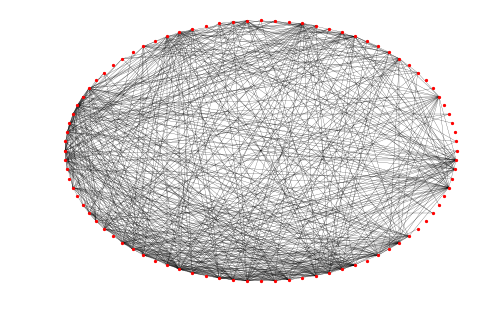

In [37]:
#with a shell or circle drawing we can see haw dense are the network
nx.draw_shell(G,
                with_labels=False,
                node_size=5,
                width=0.2,
                edge_color='black'
                )

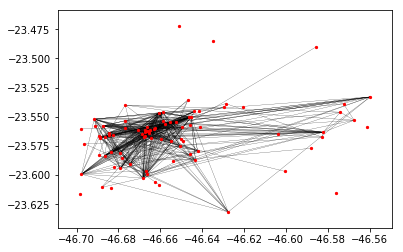

In [38]:
#retake the position of each venue.
#Naturaly, we can see the central venues are more dense, but there are 4 or 5 not celtral that are very dense
pos = {key: ([value1,value2]) for key, value1, value2 in zip(posLat.keys(), posLon.values(), posLat.values())}
#Draw the network
nx.draw_networkx(G,
                pos=pos,
                with_labels=False,
                node_size=5,
                width=0.2,
                edge_color='black'
                )

## Miscellaneous
 - work cloud
 A work cloud can be genereted based on the tips that all user did for a venue.

In [39]:
likerstips=likerstips.groupby(['VenueId'], 
                               as_index=False, 
                               sort=True).aggregate(lambda x:','.join(x))

In [40]:
tipstocloud=likerstips.merge(Venues_merged, 
                     left_on='VenueId', 
                     right_on='VenueId', 
                     how='inner').reset_index(drop=True)

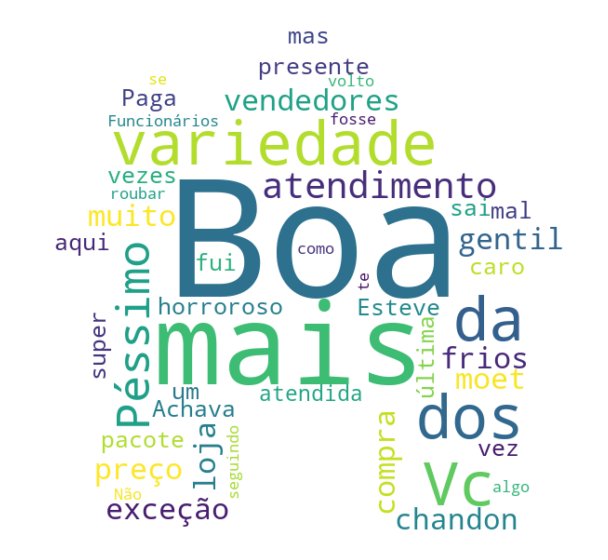

In [45]:
stopwords.add('de') # add the words said to stopwords
stopwords.add('ma') # add the words said to stopwords

# save mask to a bottle
Venue_mask = np.array(Image.open('yellow-house-hi.png'))


# instantiate a word cloud object
Venue_wc = WordCloud(background_color='white', mask=Venue_mask, stopwords=stopwords)

# generate the word cloud
Venue_wc.generate(tipstocloud['Coment Tips'][40]) # this is a very contraversal venue (Paris 6 Bistrô).

# display the word cloud
fig = plt.figure()
fig.set_figwidth(10) # set width
fig.set_figheight(10) # set height

plt.imshow(Venue_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

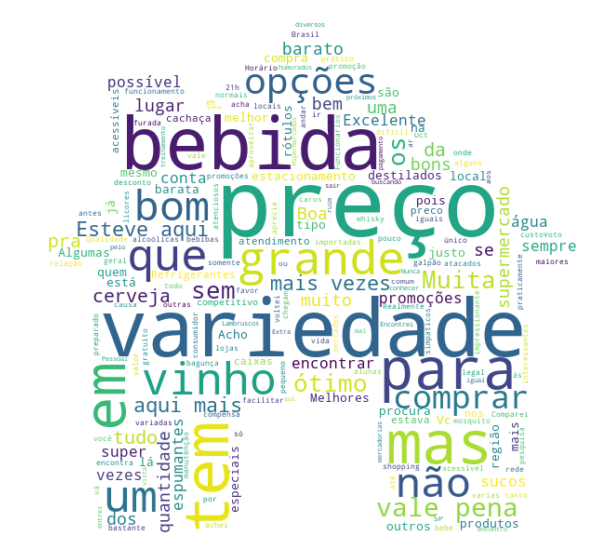

In [46]:
# instantiate a word cloud object
Venue_wc = WordCloud(background_color='white', mask=Venue_mask, stopwords=stopwords)

# generate the word cloud
Venue_wc.generate(tipstocloud['Coment Tips'][33]) # this is a good one.(Famiglia Mancini)

# display the word cloud
fig = plt.figure()
fig.set_figwidth(10) # set width
fig.set_figheight(10) # set height

plt.imshow(Venue_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

### End